### In this notebook I want to create a barplot with N on the x-axis

In [191]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [192]:
results_path = os.environ['HOME'] + '/workspace_icon-ml/symbolic_regression/evaluate_schemes/on_era5/results/era5_1979-2021/'

In [193]:
naming_dict = {'PYSR_EQ1_NM': ['era5_tuned_pysr_EQ1_mod.json', 'pysr_EQ1'],
              'PYSR_EQ1_BFGS': ['era5_tuned_pysr_EQ1_mod_BFGS.json', 'pysr_EQ1'],
              'PYSR_EQ4_NM': ['era5_tuned_pysr_EQ4_mod.json', 'pysr_EQ4_mod'],
              'PYSR_EQ4_BFGS': ['era5_tuned_pysr_EQ4_mod_BFGS.json', 'pysr_EQ4_mod'],
              'GPGOMEA_NM': ['gpgomea_equations.json', 'gpgomea_eq_3'],
              'GPGOMEA_BFGS': ['gpgomea_equations.json', 'gpgomea_eq_3'],
              'POL2_BFGS': ['sel_polyn_deg_3_BFGS.json', 'deg_3_n_feat_2'],
              'POL3_BFGS': ['sel_polyn_deg_3_BFGS.json', 'deg_3_n_feat_3'],
              'POL4_BFGS': ['sel_polyn_deg_3_BFGS.json', 'deg_3_n_feat_4'],
              'POL5_BFGS': ['sel_polyn_deg_3_BFGS.json', 'deg_3_n_feat_5'],
              'POL6_BFGS': ['sel_polyn_deg_3_BFGS.json', 'deg_3_n_feat_6'],
              'POL2_NM': ['sel_polyn_deg_3.json', 'deg_3_n_feat_2'],
              'POL3_NM': ['sel_polyn_deg_3.json', 'deg_3_n_feat_3'],
              'POL4_NM': ['sel_polyn_deg_3.json', 'deg_3_n_feat_4'],
              'POL5_NM': ['sel_polyn_deg_3.json', 'deg_3_n_feat_5'],
              'POL6_NM': ['sel_polyn_deg_3.json', 'deg_3_n_feat_6'],
              'XU-RANDALL': ['era5_xu_randall.json', 'xu_randall'],
              'COLUMN-BASED': ['column_based_nn.json', 'column-based_NN'],
              'SFS_24':['sr_based_nn.json', 'SFS_NN_24']}

for ind in range(1, 11):
    naming_dict['SFS_%d'%ind] = ['sfs_based_nn.json', 'SFS_NN_%d'%ind]

In [194]:
def get_mses_loc_based(model_name):
    # Create pd Dataframe with three columns: Transfer learn index, seed and MSE
    df = pd.DataFrame(columns=['tl_index', 'seed', 'mse'])
    
    # Load json file with MSEs
    res_json = results_path + naming_dict[model_name][0]
    with open(res_json, 'r') as file:
        d = json.load(file)
        
    # Store MSEs in Dataframe for every transfer learning setting
    # seeds = 10*np.arange(1, 11) 
    # Actually, let's just take the same seeds as for the hrs_based and cell_based:
    seeds = 10*np.arange(1, 7) 
    for tl in [0,1,2]:
        for s in seeds:
            try:
                if model_name == 'XU-RANDALL':
                    df = df.append({'tl_index': 10**tl, 'seed':s, 'mse':d['%s_tl_%d_seed_%d'%(naming_dict[model_name][1], tl, s)]['MSE_era5_tuned']}, ignore_index=True)
                else:
                    df = df.append({'tl_index': 10**tl, 'seed':s, 'mse':d['%s_tl_%d_seed_%d'%(naming_dict[model_name][1], tl, s)]['MSE']}, ignore_index=True)
            except:
                print('Missing:', model_name, tl, s)
                
    # Model evaluated directly on the ERA5 data (without transfer learning)
    if model_name == 'COLUMN-BASED':
        df = df.append({'tl_index': 0, 'seed':0, 'mse':d['%s'%(naming_dict[model_name][1])]['MSE']}, ignore_index=True)
    elif model_name in ['PYSR_EQ1_NM', 'PYSR_EQ1_BFGS']:
        df = df.append({'tl_index': 0, 'seed':0, 'mse':d['pysr_EQ1_no_tl']['MSE']}, ignore_index=True)
    elif model_name in ['PYSR_EQ4_NM', 'PYSR_EQ4_BFGS']:
        df = df.append({'tl_index': 0, 'seed':0, 'mse':d['pysr_EQ4_no_tl']['MSE']}, ignore_index=True)
    elif model_name in ['GPGOMEA_NM', 'GPGOMEA_BFGS']:
        df = df.append({'tl_index': 0, 'seed':0, 'mse':d['gpgomea_eq_3_no_tl']['MSE']}, ignore_index=True)
    elif model_name == 'XU-RANDALL':
        df = df.append({'tl_index': 0, 'seed':0, 'mse':d['%s_no_tl'%(naming_dict[model_name][1])]['MSE_era5_tuned']}, ignore_index=True)
    else:
        df = df.append({'tl_index': 0, 'seed':0, 'mse':d['%s_no_tl'%(naming_dict[model_name][1])]['MSE']}, ignore_index=True)
    
    # Add the model name
    df['hue'] = model_name

    return df

In [195]:
def get_mses_hrs_based(model_name):
    # Create pd Dataframe with three columns: Transfer learn index, seed and MSE
    df = pd.DataFrame(columns=['num_hours', 'seed', 'mse'])
    
    # Load json file with MSEs
    res_json = results_path + naming_dict[model_name][0]
    with open(res_json, 'r') as file:
        d = json.load(file)
        
    # Store MSEs in Dataframe for every transfer learning setting
    seeds = 10*np.arange(1, 7)
    for nhours in [1, 8, 32]:
        for s in seeds:
            try:
                if model_name == 'XU-RANDALL':
                    df = df.append({'num_hours': nhours, 'seed':s, 'mse':d['%s_tl_%d_num_hours_%d_seed_%d'%(naming_dict[model_name][1], 0, nhours, s)]['MSE_era5_tuned']}, \
                                   ignore_index=True)
                else:
                    df = df.append({'num_hours': nhours, 'seed':s, 'mse':d['%s_tl_%d_num_hours_%d_seed_%d'%(naming_dict[model_name][1], 0, nhours, s)]['MSE']}, \
                                   ignore_index=True)
            except:
                print('Missing:', model_name, nhours, s)
            
    # Add the model name
    df['hue'] = model_name

    return df

In [196]:
def get_mses_cell_based(model_name):
    # Create pd Dataframe with three columns: Transfer learn index, seed and MSE
    df = pd.DataFrame(columns=['num_cells', 'seed', 'mse'])
    
    # Load json file with MSEs
    res_json = results_path + naming_dict[model_name][0]
    with open(res_json, 'r') as file:
        d = json.load(file)
        
    # Store MSEs in Dataframe for every transfer learning setting
    seeds = 10*np.arange(1, 7)
    for ncells in [1, 5]:
        for s in seeds:
            try:
                if model_name == 'XU-RANDALL':
                    df = df.append({'num_cells': ncells, 'seed':s, 'mse':d['%s_tl_%d_num_cells_%d_seed_%d'%(naming_dict[model_name][1], 0, ncells, s)]['MSE_era5_tuned']}, \
                                   ignore_index=True)
                else:
                    df = df.append({'num_cells': ncells, 'seed':s, 'mse':d['%s_tl_%d_num_cells_%d_seed_%d'%(naming_dict[model_name][1], 0, ncells, s)]['MSE']}, \
                                   ignore_index=True)
            except:
                print('Missing:', model_name, ncells, s)
                
    # Add the model name
    df['hue'] = model_name

    return df

### Second version: Varying the number of hours (6 different seeds per setting). Taking just one column.

In [ ]:
mse_df_eq1_NM = get_mses_hrs_based('PYSR_EQ1_NM')
mse_df_eq4_NM = get_mses_hrs_based('PYSR_EQ4_NM')
mse_df_eq1_BFGS = get_mses_hrs_based('PYSR_EQ1_BFGS')
mse_df_eq4_BFGS = get_mses_hrs_based('PYSR_EQ4_BFGS')
mse_df_GPGOMEA_NM = get_mses_hrs_based('GPGOMEA_NM')
mse_df_GPGOMEA_BFGS = get_mses_hrs_based('GPGOMEA_BFGS')
mse_df_xu = get_mses_hrs_based('XU-RANDALL')
# mse_df_column = get_mses_hrs_based('COLUMN-BASED')
mse_df_SFS_24 = get_mses_hrs_based('SFS_24')
mse_df_pol2_BFGS = get_mses_hrs_based('POL2_BFGS')
mse_df_pol3_BFGS = get_mses_hrs_based('POL3_BFGS')
mse_df_pol4_BFGS = get_mses_hrs_based('POL4_BFGS')
mse_df_pol5_BFGS = get_mses_hrs_based('POL5_BFGS')
mse_df_pol6_BFGS = get_mses_hrs_based('POL6_BFGS')
mse_df_pol2_NM = get_mses_hrs_based('POL2_NM')
mse_df_pol3_NM = get_mses_hrs_based('POL3_NM')
mse_df_pol4_NM = get_mses_hrs_based('POL4_NM')
mse_df_pol5_NM = get_mses_hrs_based('POL5_NM')
mse_df_pol6_NM = get_mses_hrs_based('POL6_NM')

merged_df = pd.merge(mse_df_eq1_NM, mse_df_eq1_BFGS, on=['num_hours', 'seed'], suffixes=['_A', '_B'])
merged_df['mse'] = np.minimum(merged_df['mse_A'], merged_df['mse_B'])
merged_df['hue'] = 'PYSR_EQ1'
mse_df_eq1 = merged_df[['num_hours', 'seed', 'mse', 'hue']]

merged_df = pd.merge(mse_df_eq4_NM, mse_df_eq4_BFGS, on=['num_hours', 'seed'], suffixes=['_A', '_B'])
merged_df['mse'] = np.minimum(merged_df['mse_A'], merged_df['mse_B'])
merged_df['hue'] = 'PYSR_EQ4'
mse_df_eq4 = merged_df[['num_hours', 'seed', 'mse', 'hue']]

merged_df = pd.merge(mse_df_GPGOMEA_NM, mse_df_GPGOMEA_BFGS, on=['num_hours', 'seed'], suffixes=['_A', '_B'])
merged_df['mse'] = np.minimum(merged_df['mse_A'], merged_df['mse_B'])
merged_df['hue'] = 'GPGOMEA'
mse_df_GPGOMEA = merged_df[['num_hours', 'seed', 'mse', 'hue']]

for pol_ind in [2,3,4,5,6]:
    merged_df = pd.merge(locals()['mse_df_pol%d_NM'%pol_ind], locals()['mse_df_pol%d_BFGS'%pol_ind], \
                         on=['num_hours', 'seed'], suffixes=['_A', '_B'])
    merged_df['mse'] = np.minimum(merged_df['mse_A'], merged_df['mse_B'])
    merged_df['hue'] = 'pol%d'%pol_ind
    locals()['mse_df_pol%d'%pol_ind] = merged_df[['num_hours', 'seed', 'mse', 'hue']]

for ind in range(1, 11):
    locals()['mse_df_SFS_%d'%ind] = get_mses_hrs_based('SFS_%d'%ind)

mse_df_xu = mse_df_xu[mse_df_xu.mse != 'NaN']

df_combined_1 = pd.concat([mse_df_eq1, mse_df_eq4, mse_df_GPGOMEA, mse_df_xu, mse_df_SFS_6, mse_df_SFS_24], axis=0, join='inner')
df_combined_2 = pd.concat([mse_df_pol2, mse_df_pol3, mse_df_pol4, mse_df_pol5, mse_df_pol6], axis=0, join='inner')
df_combined_3 = pd.concat([globals()['mse_df_SFS_%d'%ind] for ind in range(4, 11)], axis=0, join='inner')
df_combined_opt = pd.concat([mse_df_eq1_NM, mse_df_eq1_BFGS, mse_df_eq4_NM, mse_df_eq4_BFGS, mse_df_GPGOMEA_NM, mse_df_GPGOMEA_BFGS], axis=0, join='inner')

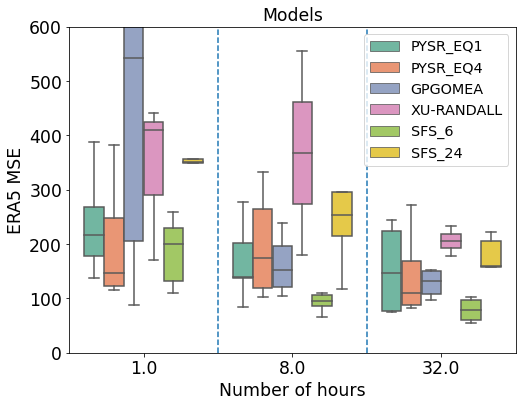

In [198]:
# Setting up the figure
fig = plt.figure(figsize=(8, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plot_titles = ['Models']

axes = tuple(np.arange(len(plot_titles)))
for i, title_name in enumerate(plot_titles):
    # Add new subplot iteratively
    ax = plt.subplot(1,1,i+1)
    axis = axes[:i] + axes[(i+1):]
    
    YMAX = 600
                
    plt.title(title_name)
    plt.vlines(0.5, 0, YMAX, ls='--')
    plt.vlines(1.5, 0, YMAX, ls='--')
    
    sns.boxplot(x='num_hours', y='mse', hue='hue', data=locals()['df_combined_%d'%(i+1)], palette="Set2", fliersize=0)

    plt.xlabel('Number of hours')
    if i in [0, 2]:
        plt.ylabel('ERA5 MSE')
    else:
        plt.ylabel('')
    plt.ylim([0,YMAX])
    plt.legend()

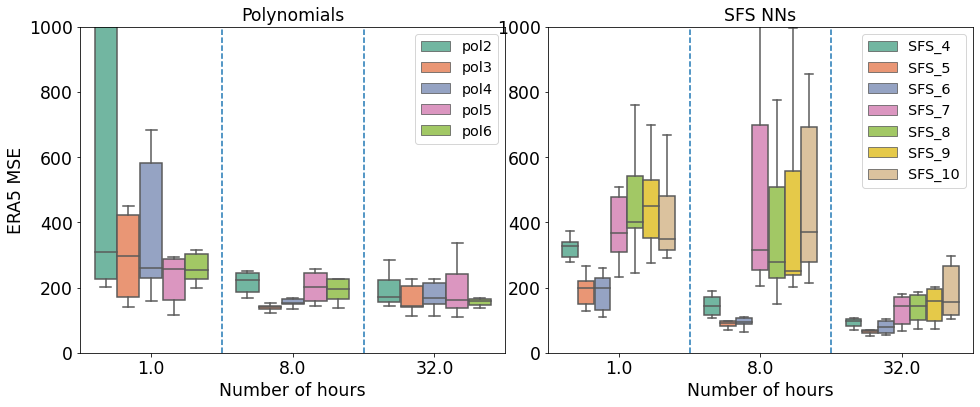

In [199]:
# Setting up the figure
fig = plt.figure(figsize=(16, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plot_titles = ['Polynomials', 'SFS NNs']

axes = tuple(np.arange(len(plot_titles)))
for i, title_name in enumerate(plot_titles):
    # Add new subplot iteratively
    ax = plt.subplot(1,2,i+1)
    axis = axes[:i] + axes[(i+1):]
    
    YMAX = 1000
                
    plt.title(title_name)
    plt.vlines(0.5, 0, YMAX, ls='--')
    plt.vlines(1.5, 0, YMAX, ls='--')
    
    sns.boxplot(x='num_hours', y='mse', hue='hue', data=locals()['df_combined_%d'%(i+2)], palette="Set2", fliersize=0)

    plt.xlabel('Number of hours')
    if i in [0, 2]:
        plt.ylabel('ERA5 MSE')
    else:
        plt.ylabel('')
    plt.ylim([0,YMAX])
    plt.legend()

### First version: Varying the number of locations (6 different seeds per setting)

In [ ]:
mse_df_eq1_NM_loc_based = get_mses_loc_based('PYSR_EQ1_NM')
mse_df_eq4_NM_loc_based = get_mses_loc_based('PYSR_EQ4_NM')
mse_df_eq1_BFGS_loc_based = get_mses_loc_based('PYSR_EQ1_BFGS')
mse_df_eq4_BFGS_loc_based = get_mses_loc_based('PYSR_EQ4_BFGS')
mse_df_GPGOMEA_NM_loc_based = get_mses_loc_based('GPGOMEA_NM')
mse_df_GPGOMEA_BFGS_loc_based = get_mses_loc_based('GPGOMEA_BFGS')
mse_df_xu_loc_based = get_mses_loc_based('XU-RANDALL')
mse_df_column_loc_based = get_mses_loc_based('COLUMN-BASED')
mse_df_SFS_24_loc_based = get_mses_loc_based('SFS_24')
mse_df_pol2_BFGS = get_mses_loc_based('POL2_BFGS')
mse_df_pol3_BFGS = get_mses_loc_based('POL3_BFGS')
mse_df_pol4_BFGS = get_mses_loc_based('POL4_BFGS')
mse_df_pol5_BFGS = get_mses_loc_based('POL5_BFGS')
mse_df_pol6_BFGS = get_mses_loc_based('POL6_BFGS')
mse_df_pol2_NM = get_mses_loc_based('POL2_NM')
mse_df_pol3_NM = get_mses_loc_based('POL3_NM')
mse_df_pol4_NM = get_mses_loc_based('POL4_NM')
mse_df_pol5_NM = get_mses_loc_based('POL5_NM')
mse_df_pol6_NM = get_mses_loc_based('POL6_NM')

merged_df = pd.merge(mse_df_eq1_NM_loc_based, mse_df_eq1_BFGS_loc_based, on=['tl_index', 'seed'], suffixes=['_A', '_B'])
merged_df['mse'] = np.minimum(merged_df['mse_A'], merged_df['mse_B'])
merged_df['hue'] = 'PYSR_EQ1'
mse_df_eq1_loc_based = merged_df[['tl_index', 'seed', 'mse', 'hue']]

merged_df = pd.merge(mse_df_eq4_NM_loc_based, mse_df_eq4_BFGS_loc_based, on=['tl_index', 'seed'], suffixes=['_A', '_B'])
merged_df['mse'] = np.minimum(merged_df['mse_A'], merged_df['mse_B'])
merged_df['hue'] = 'PYSR_EQ4'
mse_df_eq4_loc_based = merged_df[['tl_index', 'seed', 'mse', 'hue']]

merged_df = pd.merge(mse_df_GPGOMEA_NM_loc_based, mse_df_GPGOMEA_BFGS_loc_based, on=['tl_index', 'seed'], suffixes=['_A', '_B'])
merged_df['mse'] = np.minimum(merged_df['mse_A'], merged_df['mse_B'])
merged_df['hue'] = 'GPGOMEA'
mse_df_GPGOMEA_loc_based = merged_df[['tl_index', 'seed', 'mse', 'hue']]

for pol_ind in [2,3,4,5,6]:
    merged_df = pd.merge(locals()['mse_df_pol%d_NM'%pol_ind], locals()['mse_df_pol%d_BFGS'%pol_ind], \
                         on=['tl_index', 'seed'], suffixes=['_A', '_B'])
    merged_df['mse'] = np.minimum(merged_df['mse_A'], merged_df['mse_B'])
    merged_df['hue'] = 'pol%d'%pol_ind
    locals()['mse_df_pol%d_loc_based'%pol_ind] = merged_df[['tl_index', 'seed', 'mse', 'hue']]

for ind in range(1, 11):
    locals()['mse_df_SFS_%d_loc_based'%ind] = get_mses_loc_based('SFS_%d'%ind)

mse_df_xu_loc_based = mse_df_xu_loc_based[mse_df_xu_loc_based.mse != 'NaN']

df_combined_1_loc_based = pd.concat([mse_df_eq1_loc_based, mse_df_eq4_loc_based, mse_df_GPGOMEA_loc_based, mse_df_xu_loc_based, mse_df_column_loc_based, mse_df_SFS_24_loc_based], axis=0, join='inner')
df_combined_2_loc_based = pd.concat([mse_df_pol2_loc_based, mse_df_pol3_loc_based, mse_df_pol4_loc_based, mse_df_pol5_loc_based, mse_df_pol6_loc_based], axis=0, join='inner')
df_combined_3_loc_based = pd.concat([globals()['mse_df_SFS_%d_loc_based'%ind] for ind in range(1, 11)], axis=0, join='inner')
df_combined_opt_loc_based = pd.concat([mse_df_eq1_NM_loc_based, mse_df_eq1_BFGS_loc_based, mse_df_eq4_NM_loc_based, mse_df_eq4_BFGS_loc_based, mse_df_GPGOMEA_NM_loc_based, mse_df_GPGOMEA_BFGS_loc_based], axis=0, join='inner')

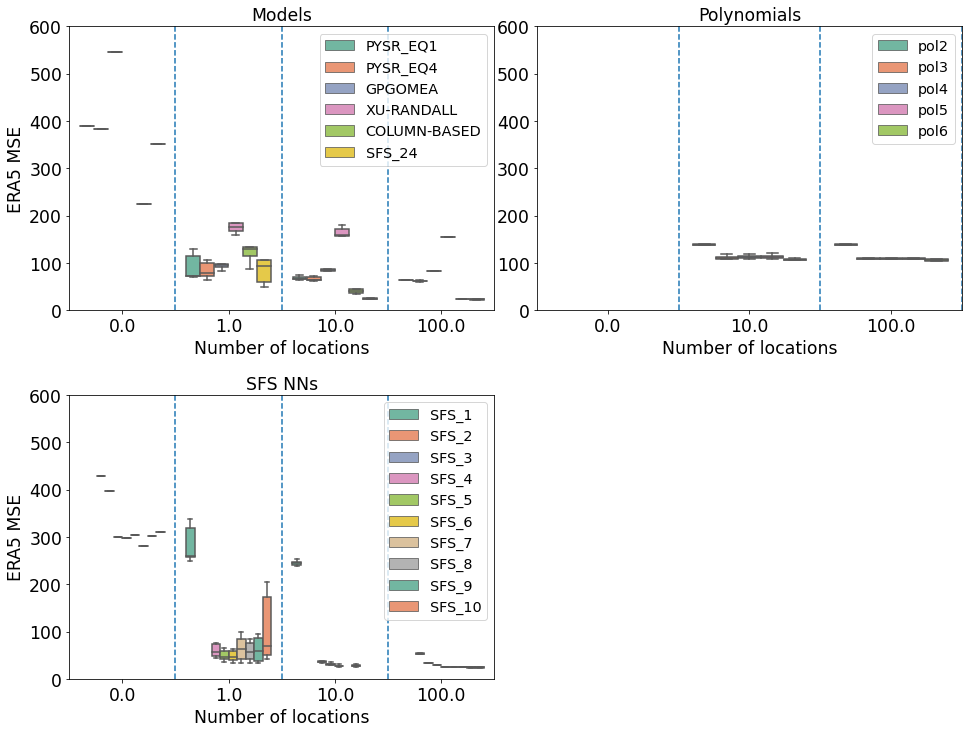

In [201]:
# Setting up the figure
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plot_titles = ['Models', 'Polynomials', 'SFS NNs']

axes = tuple(np.arange(len(plot_titles)))
for i, title_name in enumerate(plot_titles):
    # Add new subplot iteratively
    ax = plt.subplot(2,2,i+1)
    axis = axes[:i] + axes[(i+1):]
    
    YMAX = 600
                
    plt.title(title_name)
    plt.vlines(0.5, 0, YMAX, ls='--')
    plt.vlines(1.5, 0, YMAX, ls='--')
    plt.vlines(2.5, 0, YMAX, ls='--')
    
    sns.boxplot(x='tl_index', y='mse', hue='hue', data=locals()['df_combined_%d_loc_based'%(i+1)], palette="Set2", fliersize=0)

    plt.xlabel('Number of locations')
    if i in [0, 2]:
        plt.ylabel('ERA5 MSE')
    else:
        plt.ylabel('')
    plt.ylim([0,YMAX])
    plt.legend()

### Nelder-Mead vs BFGS

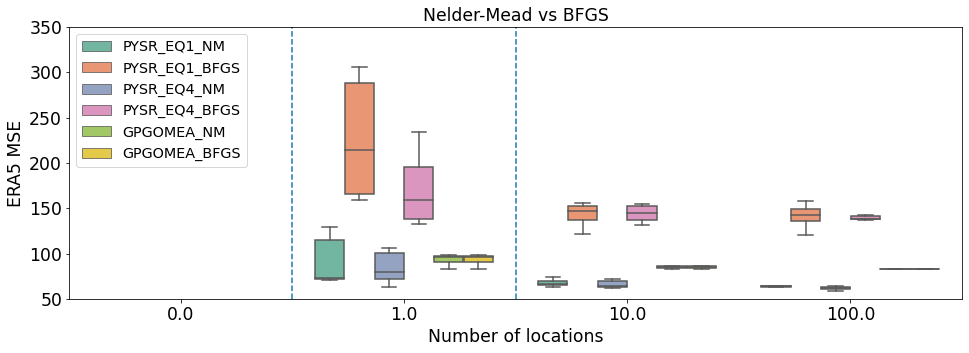

In [202]:
# Setting up the figure
fig = plt.figure(figsize=(16, 5))
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plot_titles = ['Nelder-Mead vs BFGS']

axes = tuple(np.arange(len(plot_titles)))
for i, title_name in enumerate(plot_titles):
    # Add new subplot iteratively
    ax = plt.subplot(1,1,i+1)
    axis = axes[:i] + axes[(i+1):]
                
    plt.title(title_name)
    plt.vlines(0.5, 50, 350, ls='--')
    plt.vlines(1.5, 50, 350, ls='--')
    
    sns.boxplot(x='tl_index', y='mse', hue='hue', data=df_combined_opt_loc_based, palette="Set2", fliersize=0)

    plt.xlabel('Number of locations')
    if i==0:
        plt.ylabel('ERA5 MSE')
    else:
        plt.ylabel('')
    plt.ylim([50,350])
    plt.legend()

### Check check_sum for all models
--> Checked all models (except the column-based NN)

In [203]:
result_files = os.listdir(results_path)
json_files = [result_files[k] for k in range(len(result_files)) if '.json' in result_files[k]]

In [204]:
for SEED in 10*np.arange(1, 11):
    for TL in [0,1,2]:
        # Every check_sum read after this point should be the same for a given SEED, TL pair!
        cs = None
        for F_IND in range(len(json_files)):
            with open(results_path + json_files[F_IND], 'r') as file:
                d = json.load(file)
                for key in d.keys():
                    if key.endswith('tl_%d_seed_%d'%(TL, SEED)):
                        try:
                            if cs != None:
                                assert cs == d[key]['Check_sum']
                            else:    
                                cs = d[key]['Check_sum']
                        # Column-based NN doesn't have a check_sum
                        except(KeyError): pass

### Third version: Final combination of loc-based and hours-based and cell-based

In [229]:
import matplotlib
matplotlib.rcParams['legend.fontsize'] = 'x-large'
matplotlib.rcParams['axes.titlesize'] = 'xx-large'
matplotlib.rcParams['axes.labelsize'] = 'xx-large' # For an axes xlabel and ylabel
matplotlib.rcParams['xtick.labelsize'] = 'xx-large'
matplotlib.rcParams['ytick.labelsize'] = 'xx-large'

In [206]:
dataframes = ['eq4', 'eq1', 'GPGOMEA', 'xu', 'SFS_6', 'SFS_24']

for DF in dataframes:
    mse_df_selected_1 = locals()['mse_df_%s_loc_based'%DF][locals()['mse_df_%s_loc_based'%DF]['tl_index'] == 0].copy()
    mse_df_selected_1['#Columns/#Time steps'] = '0/0'
    mse_df_selected_2 = locals()['mse_df_%s'%DF][locals()['mse_df_%s'%DF]['num_hours'] == 1].copy()
    mse_df_selected_2['#Columns/#Time steps'] = '1/1'
    mse_df_selected_3 = locals()['mse_df_%s'%DF][locals()['mse_df_%s'%DF]['num_hours'] == 32].copy()
    mse_df_selected_3['#Columns/#Time steps'] = '1/32'
    mse_df_selected_4 = locals()['mse_df_%s_loc_based'%DF][locals()['mse_df_%s_loc_based'%DF]['tl_index'] == 100].copy()
    mse_df_selected_4['#Columns/#Time steps'] = '100/1368'
    locals()['mse_df_%s_selected'%DF] = pd.concat([mse_df_selected_1, mse_df_selected_2, mse_df_selected_3, mse_df_selected_4], axis=0, join='inner')
    
mse_df_selected = pd.concat([globals()['mse_df_%s_selected'%DF] for DF in dataframes], axis=0, join='inner')

In [207]:
mse_df_selected = mse_df_selected.replace('PYSR_EQ4', 'PySR equation')
mse_df_selected = mse_df_selected.replace('PYSR_EQ1', 'PySR equation 2')
mse_df_selected = mse_df_selected.replace('SFS_6', '6-feature NN')
mse_df_selected = mse_df_selected.replace('SFS_24', '24-feature NN')
mse_df_selected = mse_df_selected.replace('GPGOMEA', 'GPGOMEA eq.')
mse_df_selected = mse_df_selected.replace('XU-RANDALL', 'Xu-Randall scheme')

In [208]:
mse_df_selected[mse_df_selected['#Columns/#Time steps'] == '0/0']

,seed,mse,hue,#Columns/#Time steps
18,0.0,382.996631,PySR equation,0/0
18,0.0,388.635855,PySR equation 2,0/0
18,0.0,546.788646,GPGOMEA eq.,0/0
18,0.0,823.834051,Xu-Randall scheme,0/0
18,0.0,297.270905,6-feature NN,0/0
18,0.0,350.588837,24-feature NN,0/0


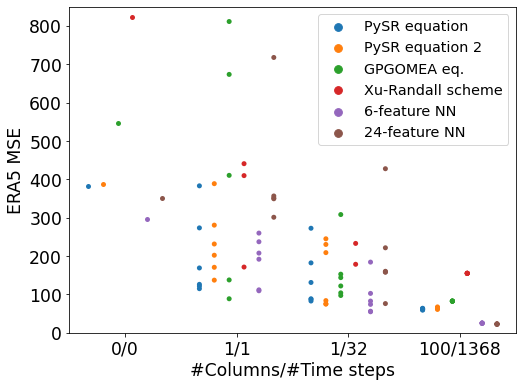

In [209]:
# Setting up the figure
fig = plt.figure(figsize=(8, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plot_titles = ['Models']

axes = tuple(np.arange(len(plot_titles)))
for i, title_name in enumerate(plot_titles):
    # Add new subplot iteratively
    ax = plt.subplot(1,1,i+1)
    axis = axes[:i] + axes[(i+1):]
    
    YMAX = 850
                
    # plt.title(title_name)
    # plt.vlines(0.5, 0, YMAX, ls='--')
    # plt.vlines(1.5, 0, YMAX, ls='--')
    
#     p = sns.Plot(mse_df_selected, "#Columns/#Time steps", color="hue")
#     p.add(sns.Bar(), sns.Count(), sns.Dodge())
    
    # sns.scatterplot(x='#Columns/#Time steps', y='mse', hue='hue', data=mse_df_selected, \
    #             palette=['brown', 'orange', 'gray', 'olive', 'cornflowerblue', 'cyan'])
    
    sns.stripplot(data=mse_df_selected, x="#Columns/#Time steps", y="mse", hue="hue", dodge=True, jitter=False)
    
    # sns.scatterplot(x='#Columns/#Time steps', y='mse', hue='hue', data=mse_df_selected, \
    #             palette=['brown', 'orange', 'gray', 'olive', 'cornflowerblue', 'cyan'])

    plt.xlabel('#Columns/#Time steps')
    if i in [0, 2]:
        plt.ylabel('ERA5 MSE')
    else:
        plt.ylabel('')
    plt.ylim([0,YMAX])
    plt.legend(loc='upper right')
    
    # plt.savefig('results/era5_1979-2021/tf_main.pdf')

In [210]:
mse_df_selected.loc[(mse_df_selected['hue'] == 'SFS24 NN') & (mse_df_selected['#Columns/#Time steps'] == '0/0')]

,seed,mse,hue,#Columns/#Time steps


In [ ]:
# Create Dataframe for medians
mse_medians_df = pd.DataFrame(columns=['#Columns/#Time steps', 'hue', 'med_mse'])

L1 = list(set(mse_df_selected['#Columns/#Time steps']))
L2 = ['PySR equation', 'PySR equation 2', 'GPGOMEA eq.', 'Xu-Randall scheme', '6-feature NN', '24-feature NN']

for l1 in L1:
    for l2 in L2:
        med = np.median(mse_df_selected.loc[(mse_df_selected['hue'] == l2) & \
                                            (mse_df_selected['#Columns/#Time steps'] == l1)]['mse'])
        mse_medians_df = mse_medians_df.append({'#Columns/#Time steps': l1, 'hue':l2, 'med_mse':med}, \
                                               ignore_index=True)

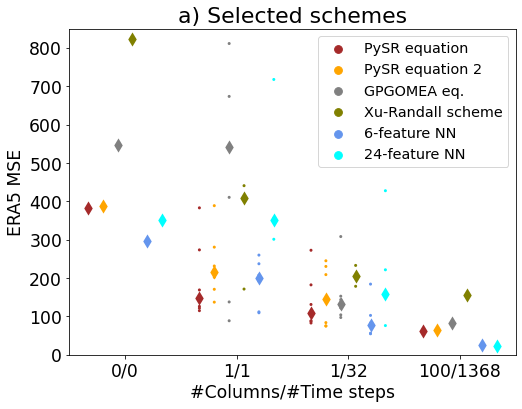

In [241]:
# Setting up the figure
fig = plt.figure(figsize=(8, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plot_titles = ['Models']

axes = tuple(np.arange(len(plot_titles)))
for i, title_name in enumerate(plot_titles):
    # Add new subplot iteratively
    ax = plt.subplot(1,1,i+1)
    axis = axes[:i] + axes[(i+1):]
    
    YMAX = 850
                
    # plt.title(title_name)
    # plt.vlines(0.5, 0, YMAX, ls='--')
    # plt.vlines(1.5, 0, YMAX, ls='--')
    

    sns.stripplot(data=mse_medians_df, x="#Columns/#Time steps", y="med_mse", hue="hue", dodge=True, jitter=False, size=5, \
             order=['0/0', '1/1', '1/32', '100/1368'], palette=['brown', 'orange', 'gray', 'olive', 'cornflowerblue', 'cyan'], marker='d', \
             s=10)
    sns.stripplot(data=mse_df_selected, x="#Columns/#Time steps", y="mse", hue="hue", dodge=True, jitter=False, size=3, \
                 order=['0/0', '1/1', '1/32', '100/1368'], palette=['brown', 'orange', 'gray', 'olive', 'cornflowerblue', 'cyan'])
    plt.legend([],[], frameon=False)
    
    # sns.scatterplot(x='#Columns/#Time steps', y='mse', hue='hue', data=mse_df_selected, \
    #             palette=['brown', 'orange', 'gray', 'olive', 'cornflowerblue', 'cyan'])

    plt.xlabel('#Columns/#Time steps')
    if i in [0, 2]:
        plt.ylabel('ERA5 MSE')
    else:
        plt.ylabel('')
    plt.ylim([0,YMAX])
    
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[6:], labels[6:], loc='upper right')
    plt.title('a) Selected schemes', size=22)
    
    plt.savefig('era5_1979-2021/tf_main_scatter.pdf')

In [213]:
np.median(mse_df_selected[(mse_df_selected['#Columns/#Time steps'] == '1/32') & (mse_df_selected['hue'] == 'PySR equation')]['mse'])

109.90042443028076

In [ ]:
np.median(mse_df_selected[(mse_df_selected['#Columns/#Time steps'] == '1/32') & (mse_df_selected['hue'] == 'SFS6 NN')]['mse'])

In [215]:
109.9-78.4

31.5

In [216]:
dataframes = ['pol2', 'pol3', 'pol4', 'pol5', 'pol6', 'SFS_4', 'SFS_5', 'SFS_6', 'SFS_7', 'SFS_8', 'SFS_9', 'SFS_10']

for DF in dataframes:
    mse_df_selected_1 = locals()['mse_df_%s_loc_based'%DF][locals()['mse_df_%s_loc_based'%DF]['tl_index'] == 0].copy()
    mse_df_selected_1['#Columns/#Time steps'] = '0/0'
    mse_df_selected_2 = locals()['mse_df_%s'%DF][locals()['mse_df_%s'%DF]['num_hours'] == 1].copy()
    mse_df_selected_2['#Columns/#Time steps'] = '1/1'
    mse_df_selected_3 = locals()['mse_df_%s'%DF][locals()['mse_df_%s'%DF]['num_hours'] == 32].copy()
    mse_df_selected_3['#Columns/#Time steps'] = '1/32'
    mse_df_selected_4 = locals()['mse_df_%s_loc_based'%DF][locals()['mse_df_%s_loc_based'%DF]['tl_index'] == 100].copy()
    mse_df_selected_4['#Columns/#Time steps'] = '100/1368'
    locals()['mse_df_%s_selected'%DF] = pd.concat([mse_df_selected_1, mse_df_selected_2, mse_df_selected_3, mse_df_selected_4], axis=0, join='inner')
    
df_selected_combined_1 = pd.concat([globals()['mse_df_%s_selected'%DF] for DF in ['SFS_4', 'SFS_5', 'SFS_6', 'SFS_7', 'SFS_8', 'SFS_9', 'SFS_10']], \
                                       axis=0, join='inner')
df_selected_combined_2 = pd.concat([globals()['mse_df_%s_selected'%DF] for DF in ['pol2', 'pol3', 'pol4', 'pol5', 'pol6']], axis=0, join='inner')

In [217]:
df_selected_combined_1 = df_selected_combined_1.replace('SFS_4', '4-feat NN')
df_selected_combined_1 = df_selected_combined_1.replace('SFS_5', '5-feat NN')
df_selected_combined_1 = df_selected_combined_1.replace('SFS_6', '6-feat NN')
df_selected_combined_1 = df_selected_combined_1.replace('SFS_7', '7-feat NN')
df_selected_combined_1 = df_selected_combined_1.replace('SFS_8', '8-feat NN')
df_selected_combined_1 = df_selected_combined_1.replace('SFS_9', '9-feat NN')
df_selected_combined_1 = df_selected_combined_1.replace('SFS_10', '10-feat NN')

df_selected_combined_2 = df_selected_combined_2.replace('pol2', '2-feat pol')
df_selected_combined_2 = df_selected_combined_2.replace('pol3', '3-feat pol')
df_selected_combined_2 = df_selected_combined_2.replace('pol4', '4-feat pol')
df_selected_combined_2 = df_selected_combined_2.replace('pol5', '5-feat pol')
df_selected_combined_2 = df_selected_combined_2.replace('pol6', '6-feat pol')

In [ ]:
# Create Dataframe for medians (SFS NNs)
mse_medians_df_1 = pd.DataFrame(columns=['#Columns/#Time steps', 'hue', 'med_mse'])

L1 = list(set(df_selected_combined_1['#Columns/#Time steps']))
L2 = ['4-feat NN', '5-feat NN', '6-feat NN', '7-feat NN', '8-feat NN', '9-feat NN', '10-feat NN']

for l1 in L1:
    for l2 in L2:
        med = np.median(df_selected_combined_1.loc[(df_selected_combined_1['hue'] == l2) & \
                                            (df_selected_combined_1['#Columns/#Time steps'] == l1)]['mse'])
        mse_medians_df_1 = mse_medians_df_1.append({'#Columns/#Time steps': l1, 'hue':l2, 'med_mse':med}, \
                                               ignore_index=True)
        
# Create Dataframe for medians (Polynomials)
mse_medians_df_2 = pd.DataFrame(columns=['#Columns/#Time steps', 'hue', 'med_mse'])

L1 = list(set(df_selected_combined_2['#Columns/#Time steps']))
L2 = ['2-feat pol', '3-feat pol', '4-feat pol', '5-feat pol', '6-feat pol']

for l1 in L1:
    for l2 in L2:
        med = np.median(df_selected_combined_2.loc[(df_selected_combined_2['hue'] == l2) & \
                                            (df_selected_combined_2['#Columns/#Time steps'] == l1)]['mse'])
        mse_medians_df_2 = mse_medians_df_2.append({'#Columns/#Time steps': l1, 'hue':l2, 'med_mse':med}, \
                                               ignore_index=True)

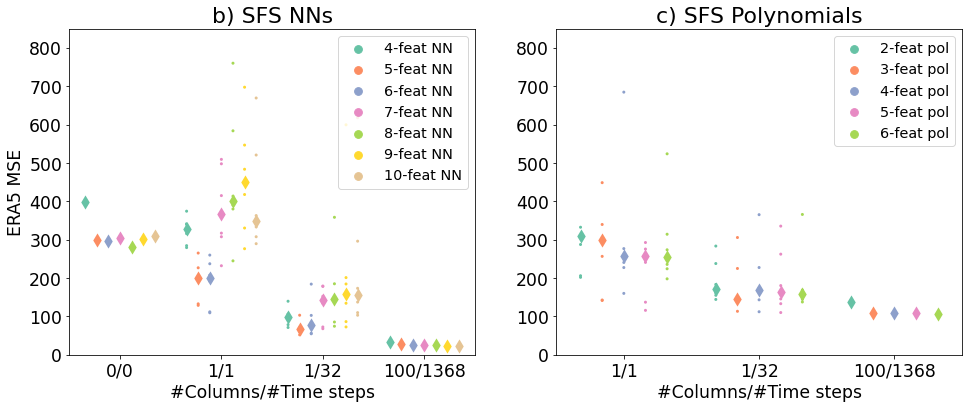

In [244]:
# Setting up the figure
fig = plt.figure(figsize=(16, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plot_titles = ['b) SFS NNs', 'c) SFS Polynomials']

axes = tuple(np.arange(len(plot_titles)))
for i, title_name in enumerate(plot_titles):
    # Add new subplot iteratively
    ax = plt.subplot(1,2,i+1)
    axis = axes[:i] + axes[(i+1):]
    
    YMAX = 850
                
    plt.title(title_name, size=22)
    # plt.vlines(0.5, 0, YMAX, ls='--')
    # plt.vlines(1.5, 0, YMAX, ls='--')
    
    if i == 0:
        order=['0/0', '1/1', '1/32', '100/1368']
    elif i == 1:
        order=['1/1', '1/32', '100/1368']
        
    sns.stripplot(data=locals()['mse_medians_df_%d'%(i+1)], x="#Columns/#Time steps", y="med_mse", hue="hue", dodge=True, jitter=False, size=5, \
             order=order, palette="Set2", marker='d', \
             s=10)
    sns.stripplot(data=locals()['df_selected_combined_%d'%(i+1)], x="#Columns/#Time steps", y="mse", hue="hue", dodge=True, jitter=False, size=3, \
                 order=order, palette="Set2")
    plt.legend([],[], frameon=False)

    plt.xlabel('#Columns/#Time steps')
    if i in [0, 2]:
        plt.ylabel('ERA5 MSE')
    else:
        plt.ylabel('')
    plt.ylim([0,YMAX])

    handles, labels = ax.get_legend_handles_labels()
    if i == 0:
        plt.legend(handles[:7], labels[:7], loc='upper right')
    else:
        plt.legend(handles[:5], labels[:5], loc='upper right')
    
    plt.savefig('era5_1979-2021/tf_add_scatter.pdf')

In [220]:
# Between 1320 and 1430
df_selected_combined_2[df_selected_combined_2['#Columns/#Time steps'] == '0/0']

,seed,mse,hue,#Columns/#Time steps
12,0.0,1427.618702,2-feat pol,0/0
12,0.0,1322.409497,3-feat pol,0/0
12,0.0,1375.665345,4-feat pol,0/0
12,0.0,1324.532187,5-feat pol,0/0
12,0.0,1361.881785,6-feat pol,0/0


### Relating complexity and accuracy with the ability of a model to transfer learn with few samples only

In [36]:
dataframes = ['eq4', 'eq1', 'GPGOMEA', 'xu', 'SFS_6', 'SFS_24', 'pol2', 'pol3', 'pol4', \
              'pol5', 'pol6', 'SFS_4', 'SFS_5', 'SFS_6', 'SFS_7', 'SFS_8', 'SFS_9', 'SFS_10']

for DF in dataframes:
    locals()['mse_df_1_%s_selected'%DF] = locals()['mse_df_%s'%DF][locals()['mse_df_%s'%DF]['num_hours'] == 1].copy()
    locals()['mse_df_2_%s_selected'%DF] = locals()['mse_df_%s_loc_based'%DF][locals()['mse_df_%s_loc_based'%DF]['tl_index'] == 100].copy()
    
df_1 = pd.concat([globals()['mse_df_1_%s_selected'%DF] for DF in dataframes], axis=0, join='inner')
df_2 = pd.concat([globals()['mse_df_2_%s_selected'%DF] for DF in dataframes], axis=0, join='inner')

In [37]:
tl_ability_1 = {}
tl_ability_2 = {}

models = list(set(df_2['hue']))

for model in models:
    mse_11 = np.median(df_1[df_1['hue'] == model]['mse']) # MSE on 1/1
    mse_full = np.median(df_2[df_2['hue'] == model]['mse']) # MSE on 100/1368
    
    tl_ability_1[model] = mse_11
    tl_ability_2[model] = mse_11 - mse_full

In [82]:
indices = np.argsort(list(tl_ability_1.values()))
keys = np.array(list(tl_ability_1.keys()))[indices]

for key in keys:
    print(key, np.round(tl_ability_1[key], 3))
    
# SFS_10 348.039
# SFS_7 365.989
# SFS_8 401.489
# SFS_9 450.649

PYSR_EQ4 147.619
SFS_5 199.568
SFS_6 199.761
PYSR_EQ1 216.797
POL6 254.611
POL5 258.25
POL4 258.698
POL3 298.077
POL2 309.958
SFS_4 327.671
SFS_24 351.395
SFS_8 401.489
XU-RANDALL 409.646
GPGOMEA 541.859


In [83]:
indices = np.argsort(list(tl_ability_2.values()))
keys = np.array(list(tl_ability_2.keys()))[indices]

for key in keys:
    print(key, np.round(tl_ability_2[key], 3))
    
# SFS_10 324.103
# SFS_7 340.412
# SFS_8 376.439
# SFS_9 426.72

PYSR_EQ4 86.032
POL6 149.076
POL5 149.467
POL4 150.055
PYSR_EQ1 152.308
SFS_5 170.855
POL2 172.109
SFS_6 174.739
POL3 189.054
XU-RANDALL 254.697
SFS_4 294.361
SFS_24 328.715
SFS_8 376.439
GPGOMEA 459.305


Broken-rational

In [ ]:
tl_ability = {}

models = list(set(df_2['hue']))

for model in models:
    
    mse_11 = np.median(df_1[df_1['hue'] == model]['mse']) # MSE on 1/1
    mse_full = np.median(df_2[df_2['hue'] == model]['mse']) # MSE on 100/1368

    # How much do I want to punish a high MSE on 1/1
    K = 100

    # Ability to transfer-learn
    # tl_ability[model] = 100/(K*mse_11 - mse_full)
    
    # Inability to transfer learn, weighted equally
    tl_ability[model] = 2*mse_11 - mse_full

In [ ]:
indices = np.argsort(list(tl_ability.values()))
keys = np.array(list(tl_ability.keys()))[indices]

for key in np.flip(keys):
    print(key, np.round(tl_ability[key], 3))

POL2 nan
POL4 nan
POL6 nan
POL5 nan
POL3 nan
GPGOMEA 1001.164
SFS_9 877.369
SFS_8 777.928
SFS_7 706.401
SFS_24 680.11
SFS_10 672.142
XU-RANDALL 664.344
SFS_4 622.032
SFS_6 374.5
SFS_5 370.489
PYSR_EQ1 369.105
PYSR_EQ4 233.651


1/L2norm

In [50]:
tl_ability = {}

models = list(set(df_2['hue']))

for model in models:
    
    mse_11 = np.median(df_1[df_1['hue'] == model]['mse']) # MSE on 1/1
    mse_full = np.median(df_2[df_2['hue'] == model]['mse']) # MSE on 100/1368

    # Ability to transfer-learn
    tl_ability[model] = 10**3/np.sqrt((mse_11**2 + (mse_11 - mse_full)**2))

In [51]:
indices = np.argsort(list(tl_ability.values()))
keys = np.array(list(tl_ability.keys()))[indices]

for key in np.flip(keys):
    print(key, np.round(tl_ability[key], 3))

PYSR_EQ4 5.853
SFS_5 3.806
PYSR_EQ1 3.774
SFS_6 3.768
POL6 3.389
POL5 3.351
POL4 3.344
POL3 2.833
POL2 2.821
SFS_4 2.27
SFS_24 2.078
XU-RANDALL 2.073
SFS_8 1.817
GPGOMEA 1.408


### Cloud Cover variance

In [7]:
# 324.2676
np.var(data_dict['cc'][:, 4:])

324.2676

In [23]:
1-280/324.2676

0.13651564325267163

In [34]:
1-150/324.2676

0.5374190945996455

In [35]:
1-220/324.2676

0.32154800541281336